# Load libraries

In [1]:
import tensorflow as tf
import numpy as np
import copy
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.profiler import trace
from tensorflow.python.keras import callbacks as callbacks_module
from tensorflow.python.keras.engine import training_utils

# Load dataset

In [3]:
X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
num_features = X_train.shape[1]

In [4]:
GLOBAL_BATCH_SIZE = 32
EPOCHS = 1

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, to_categorical(y_train))).batch(GLOBAL_BATCH_SIZE, ) #steps_per_epoch
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, to_categorical(y_test))).batch(GLOBAL_BATCH_SIZE, )

In [6]:
seed = 11

In [7]:
layers = [
    tf.keras.layers.Dense(16, activation='relu', input_shape = (num_features,), kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1)),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1) ),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1) ),
]

layers_clone = copy.deepcopy(layers)

# Comparison: keras model vs. customized

## Experiment 1

* reference: https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#a_first_simple_example

### keras model

In [8]:
tf.random.set_seed(seed)

model = Sequential()
for layer in layers_clone:
    model.add(layer)

Loss = BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adagrad(learning_rate=1e-2)

model.compile(optimizer = optimizer, loss = Loss, metrics = ['acc'], )

### custom model

In [9]:
model_custom = tf.keras.models.clone_model(model)
model_custom.set_weights(model.get_weights())

weights_custom = copy.deepcopy(model_custom.trainable_variables)

Loss_custom = copy.deepcopy(Loss)
optimizer_custom = copy.deepcopy(optimizer)

model_custom.compile(optimizer = optimizer_custom, loss = [Loss_custom], metrics = ['acc'], )

In [10]:
opt_wei = []
grads = []

In [11]:
ith_batch = 0
for xt, yt in train_dataset:
    with tf.GradientTape() as tape:
#         tape.reset()
        f = model_custom(xt, training=True)
        loss = model_custom.compiled_loss(yt, f, regularization_losses=model_custom.losses)
        print('{}th batch loss:'.format(str(ith_batch).zfill(2)), loss.numpy())
#         loss = Loss(yt, f)

    grad = tape.gradient(loss, model_custom.trainable_variables)
    optimizer_custom.apply_gradients(zip(grad, model_custom.trainable_variables))
    
    ith_batch+=1
    opt_wei.append(optimizer.weights)
    grads.append(grad)

00th batch loss: 0.95477647
01th batch loss: 0.82564175
02th batch loss: 0.802238
03th batch loss: 0.85181713
04th batch loss: 0.77963877
05th batch loss: 0.7995611
06th batch loss: 0.7566784
07th batch loss: 0.72384125
08th batch loss: 0.7095673
09th batch loss: 0.7580291
10th batch loss: 0.70888746
11th batch loss: 0.67985237
12th batch loss: 0.683792
13th batch loss: 0.79725015
14th batch loss: 0.670355


In [12]:
model.fit(train_dataset, shuffle=False, epochs=1, verbose=1)

15/15 [==============================] - 0s 1ms/step - loss: 0.7721 - acc: 0.3187


### comparison

In [13]:
for iw in range(len(model_custom.weights)):
    print(
#         np.alltrue(m.weights[iw] == model.weights[iw]), 
          np.allclose(model_custom.weights[iw], model.weights[iw]), abs(model_custom.weights[iw] - model.weights[iw]).numpy().max())

True 2.9802322e-08
True 2.3283064e-10
True 7.450581e-09
True 0.0
True 9.313226e-10
True 3.7252903e-09


In [14]:
for iow in range(len(model_custom.optimizer.weights)):
    print(iow, abs(model.optimizer.weights[iow] -  model_custom.optimizer.weights[iow]).numpy().max())
#     print(np.unique((model.optimizer.weights[iow]== optimizer.weights[iow]), return_counts=True))
    print(np.unique(np.isclose(model.optimizer.weights[iow], model_custom.optimizer.weights[iow], rtol=1e-5), return_counts=True))

0 0
(array([ True]), array([1], dtype=int64))
1 1.4901161e-08
(array([ True]), array([480], dtype=int64))
2 7.450581e-09
(array([ True]), array([16], dtype=int64))
3 1.4901161e-08
(array([ True]), array([64], dtype=int64))
4 0.0
(array([ True]), array([4], dtype=int64))
5 1.4901161e-08
(array([ True]), array([8], dtype=int64))
6 0.0
(array([ True]), array([2], dtype=int64))


In [65]:
nth_layer = 0

In [66]:
pred = copy.deepcopy(weights_custom[nth_layer])
for it in range(len(grads)):
    h = (tf.sqrt(opt_wei[it][nth_layer+1] )   + optimizer_custom.epsilon  ) 
    pred = pred - (optimizer_custom.learning_rate * (grads[it][nth_layer]/h))    

In [67]:
true = model.trainable_variables[nth_layer]
# true

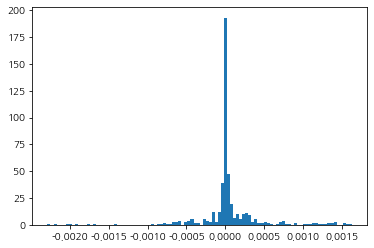

In [68]:
plt.hist(tf.reshape(true - pred, [-1,]).numpy(), bins=100)
plt.show()

In [69]:
np.unique(np.isclose(true , pred), return_counts=True)

(array([False,  True]), array([436,  44], dtype=int64))

## Experiment 2

* reference: https://www.tensorflow.org/tutorials/distribute/custom_training

In [15]:
strategy = Sequential().distribute_strategy #tf.distribute.MirroredStrategy()
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

In [16]:
print ('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [17]:
seed = 34954303

In [18]:
# opt_wei = []
# grads = []

### custom model

In [28]:
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
#         print(x.numpy().shape)
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
#             loss = self.loss(y, y_pred,)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        print('..')
        
#         opt_wei.append(self.optimizer.weights)
#         grads.append(gradients)
        
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [29]:
def create_model(layers, seed):
    tf.random.set_seed(seed)
    inputs = tf.keras.Input(shape=(num_features,))
    for layer_index, layer in enumerate(layers):
        if layer_index == 0:
            x = layer(inputs)
        else:
            x = layer(x)
#     x = tf.keras.layers.Dense(16, activation='relu', kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1))(inputs)
#     x = tf.keras.layers.Dense(4, activation='relu', kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1) )(x)
#     x = tf.keras.layers.Dense(2, activation='sigmoid', kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1) )(x)
    model_ = CustomModel(inputs, x)
    
    return model_

In [10]:
# def create_model(seed):
#     tf.random.set_seed(seed)
#     model = Sequential()
    
#     model.add(tf.keras.layers.Dense(16, activation='relu', input_shape = (num_features,), kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1)))
#     model.add(tf.keras.layers.Dense(4, activation='relu', kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1) ))
#     model.add(tf.keras.layers.Dense(2, activation='sigmoid', kernel_initializer = tf.keras.initializers.GlorotNormal(seed=1) ))
    
#     return model

In [30]:
layer_clone = copy.deepcopy(layers)

In [31]:
with strategy.scope():
  # Set reduction to `none` so we can do the reduction afterwards and divide by
  # global batch size.
    loss_object = tf.keras.losses.BinaryCrossentropy(
#       from_logits=True,
#       reduction=tf.keras.losses.Reduction.NONE
                  )
    def compute_loss(labels, predictions):
        per_example_loss = loss_object(labels, predictions)
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

#     test_loss = tf.keras.metrics.Mean(name='test_loss')

#     train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
#     test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')

In [32]:
with strategy.scope():
    model_custom1 = create_model(layer_clone, seed)
    weights_custom1 = copy.deepcopy(model_custom1.trainable_variables)

    optimizer_custom1 = tf.keras.optimizers.Adagrad(1e-2)

    checkpoint = tf.train.Checkpoint(optimizer=optimizer_custom1, model=model_custom1)
    model_custom1.compile(optimizer=optimizer_custom1, loss = loss_object, 
                          metrics = ['acc']
                         )

    model_custom1.train_function = model_custom1.make_train_function()

In [92]:
# def train_step(inputs):
#     images, labels = inputs

#     with tf.GradientTape() as tape:
#         predictions = model_custom1(images, training=True)
#         loss = compute_loss(labels, predictions)

#     gradients = tape.gradient(loss, model_custom1.trainable_variables)
#     optimizer_custom1.apply_gradients(zip(gradients, model_custom1.trainable_variables))

# #     train_accuracy.update_state(labels, predictions)
#     return loss 

# @tf.function
# def distributed_train_step(dataset_inputs):
#   per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))
#   return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
#                          axis=None)

# @tf.function
# def distributed_test_step(dataset_inputs):
#   return strategy.run(test_step, args=(dataset_inputs,))

In [33]:

for epoch in range(EPOCHS):
  # TRAIN LOOP
    total_loss = 0.0
    num_batches = 0
    train_iter = iter(train_dist_dataset)
    
    for x in train_dataset:
#       print(distributed_train_step(x), distributed_train_step(next(train_iter)))
#       total_loss += model_custom1.train_function()

        add_loss = model_custom1.train_function(train_iter) #distributed_train_step(next(train_iter))
        print('  Batch: {}, loss: {}, acc: {}'.format(str(num_batches).zfill(3), add_loss['loss'].numpy(), add_loss['acc'].numpy()), )
        
        total_loss += add_loss['loss']
        num_batches += 1
        
    train_loss = total_loss / num_batches

  # TEST LOOP
#   for x in test_dist_dataset:
#     distributed_test_step(x)

#   if epoch % 2 == 0:
#     checkpoint.save(checkpoint_prefix)

    print('Epoch: {}, loss: {}'.format(str(epoch+1).zfill(2), train_loss), )
    
#     template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, "
#               "Test Accuracy: {}")
  
#   print (template.format(epoch+1, train_loss,
#                          train_accuracy.result()*100, test_loss.result(),
#                          test_accuracy.result()*100))

#   test_loss.reset_states()
#   train_accuracy.reset_states()
#   test_accuracy.reset_states()

..
..
  Batch: 000, loss: 0.8209180235862732, acc: 0.375
  Batch: 001, loss: 0.900952935218811, acc: 0.328125
  Batch: 002, loss: 0.8808948993682861, acc: 0.3229166567325592
  Batch: 003, loss: 0.8859827518463135, acc: 0.3125
  Batch: 004, loss: 0.8820684552192688, acc: 0.33125001192092896
  Batch: 005, loss: 0.872550904750824, acc: 0.3385416567325592
  Batch: 006, loss: 0.8528721928596497, acc: 0.3526785671710968
  Batch: 007, loss: 0.8475878834724426, acc: 0.35546875
  Batch: 008, loss: 0.8376209139823914, acc: 0.3541666567325592
  Batch: 009, loss: 0.8294330835342407, acc: 0.35624998807907104
  Batch: 010, loss: 0.819271445274353, acc: 0.375
  Batch: 011, loss: 0.8170177340507507, acc: 0.3854166567325592
  Batch: 012, loss: 0.812931478023529, acc: 0.39423078298568726
  Batch: 013, loss: 0.8097837567329407, acc: 0.3883928656578064
  Batch: 014, loss: 0.8098143339157104, acc: 0.3890109956264496
Epoch: 01, loss: 0.8453133702278137


### keras model

* reference: https://github.com/tensorflow/tensorflow/blob/07acf0f4e07678a63667e0aad88ce2485b31d619/tensorflow/python/keras/engine/training.py#L1136-L1196

In [25]:
tf.random.set_seed(seed)
layer_clone = copy.deepcopy(layers)

model = Sequential()
for layer in layer_clone:
    model.add(layer)

Loss = BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adagrad(learning_rate=1e-2)

model.compile(optimizer = optimizer, loss = Loss, metrics = ['acc'], )


batch_size=None
verbose=1
callbacks=None
validation_split=0.
validation_data=None
shuffle=False
class_weight=None
sample_weight=None
initial_epoch=0
steps_per_epoch=None
validation_steps=None
validation_batch_size=None
validation_freq=1
max_queue_size=10
workers=1
use_multiprocessing=False

with model.distribute_strategy.scope(), training_utils.RespectCompiledTrainableState(model):
  # Creates a `tf.data.Dataset` and handles batch and epoch iteration.
    data_handler = data_adapter.get_data_handler(
      x=train_dataset,
#           y=y,
      sample_weight=sample_weight,
      batch_size=batch_size,
      steps_per_epoch=steps_per_epoch,
      initial_epoch=initial_epoch,
      epochs=EPOCHS,
      shuffle=shuffle,
      class_weight=class_weight,
      max_queue_size=max_queue_size,
      workers=workers,
      use_multiprocessing=use_multiprocessing,
      model=model,
      steps_per_execution=model._steps_per_execution)

  # Container that configures and calls `tf.keras.Callback`s.
    if not isinstance(callbacks, callbacks_module.CallbackList):
        callbacks = callbacks_module.CallbackList(
            callbacks,
            add_history=True,
            add_progbar=verbose != 0,
            model=model,
            verbose=verbose,
            epochs=EPOCHS,
            steps=data_handler.inferred_steps)

    model.stop_training = False
    model.train_function = model.make_train_function()
    model._train_counter.assign(0)
    callbacks.on_train_begin()
    training_logs = None
    # Handle fault-tolerance for multi-worker.
    # TODO(omalleyt): Fix the ordering issues that mean this has to
    # happen after `callbacks.on_train_begin`.
    data_handler._initial_epoch = (  # pylint: disable=protected-access
      model._maybe_load_initial_epoch_from_ckpt(initial_epoch))
    logs = None
    for epoch, iterator in data_handler.enumerate_epochs():
        print('epoch',epoch)
    #     master, copy1 = itertools.tee(iterator)
    #     ms = copy.copy(copy1)
    #     print(len(list(ms)))
    #     itr = copy.deepcopy(list(iterator))
    #     print(len(list(iterator)))
        model.reset_metrics()
        callbacks.on_epoch_begin(epoch)
        with data_handler.catch_stop_iteration():
            for step in data_handler.steps():
                with trace.Trace(
                    'train',
                    epoch_num=epoch,
                    step_num=step,
                    batch_size=batch_size,
                    _r=1):
#           master, copy1 = itertools.tee(iterator)
#           ms = copy.copy(copy1)
#           print(len(list(copy1)))
                    callbacks.on_train_batch_begin(step)
                    tmp_logs = model.train_function(iterator)
                    print('\n step:',step,'loss, acc:', tmp_logs['loss'].numpy(), tmp_logs['acc'].numpy())
            
                    if data_handler.should_sync: context.async_wait()
                    logs = tmp_logs  # No error, now safe to assign to logs.
                    end_step = step + data_handler.step_increment
                    callbacks.on_train_batch_end(end_step, logs)
                    if model.stop_training:break

epoch 0

 step: 0 loss, acc: 0.820918 0.375
 1/15 [=>............................] - ETA: 2s - loss: 0.8209 - acc: 0.3750
 step: 1 loss, acc: 0.90095294 0.328125

 step: 2 loss, acc: 0.8808949 0.32291666

 step: 3 loss, acc: 0.88598275 0.3125

 step: 4 loss, acc: 0.88206846 0.33125

 step: 5 loss, acc: 0.8725509 0.33854166

 step: 6 loss, acc: 0.8528722 0.35267857

 step: 7 loss, acc: 0.8475879 0.35546875

 step: 8 loss, acc: 0.8376209 0.35416666

 step: 9 loss, acc: 0.8294331 0.35625

 step: 10 loss, acc: 0.81927145 0.375

 step: 11 loss, acc: 0.81701773 0.38541666

 step: 12 loss, acc: 0.8129315 0.39423078

 step: 13 loss, acc: 0.80978376 0.38839287

 step: 14 loss, acc: 0.80981433 0.389011


### comparison

In [26]:
for iw in range(len(model.weights)):
    print(np.alltrue(model.weights[iw] == model_custom1.weights[iw]))

True
True
True
True
True
True


In [27]:
for iow in range(len(model.optimizer.weights)):
    print(np.unique((model.optimizer.weights[iow] == model_custom1.optimizer.weights[iow]), return_counts=True))

(array([ True]), array([1], dtype=int64))
(array([ True]), array([480], dtype=int64))
(array([ True]), array([16], dtype=int64))
(array([ True]), array([64], dtype=int64))
(array([ True]), array([4], dtype=int64))
(array([ True]), array([8], dtype=int64))
(array([ True]), array([2], dtype=int64))


In [111]:
nth_layer = 0

In [ ]:
pred = copy.deepcopy(weights_custom1[nth_layer])
for it in range(len(grads)):
    h = (tf.sqrt(opt_wei[it][nth_layer+1] )   + model_custom1.optimizer.epsilon  ) 
    pred = pred - (model_custom1.optimizer.learning_rate * (grads[it][nth_layer]/h))    

In [448]:
# h = (tf.sqrt(optimizer.weights[nth_layer+1])  + optimizer.epsilon   ) 
# pred = w[nth_layer] - ((optimizer.learning_rate * grad[nth_layer])/h)    
# # pred

In [449]:
true = model.trainable_variables[nth_layer]
# true